In [158]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import pandas as pd

import networkx as nx
from timagetk.io import imread
from timagetk.components.labelled_image import LabelledImage
from timagetk.components.spatial_image import SpatialImage
# from timagetk.visu.util import glasbey

from ctrl.algorithm.image_overlap import cell_overlap
import cv2

from auxiliary import values as v
from auxiliary.data import imaging

from auxiliary.data.dataset_ht import HtDataset
import json


import json

Generate artificial image with circles

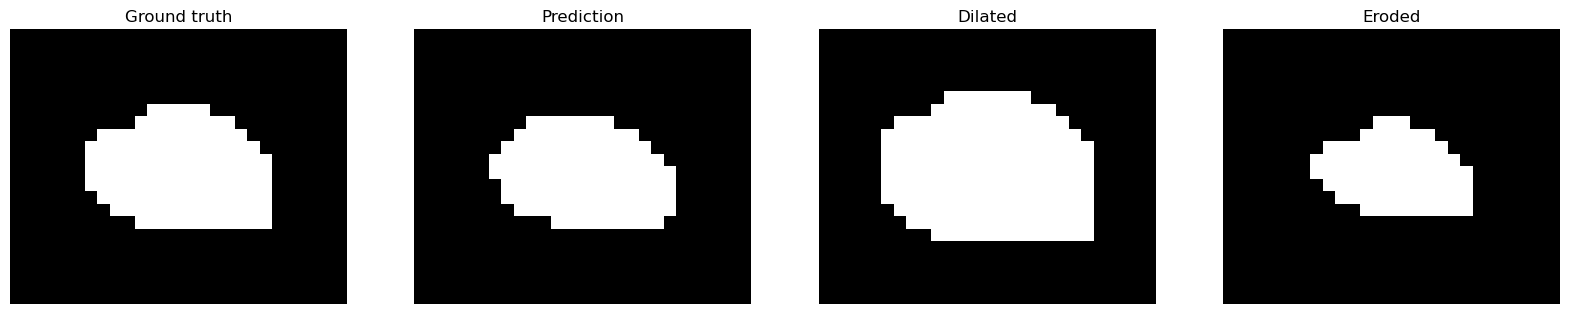

In [111]:
img_gt = imaging.read_image('../nuclei_segmentation/crop_gt.tif')
img_pred = imaging.read_image('../nuclei_segmentation/crop_pred.tif')

img_dilated = np.swapaxes(np.swapaxes([
    cv2.dilate(img_gt[..., z], np.ones((3, 3), np.uint8), iterations=1)
    for z in range(img_gt.shape[-1])
], 0, 2), 0, 1)

img_eroded = np.swapaxes(np.swapaxes([
    cv2.erode(img_gt[..., z], np.ones((3, 3), np.uint8), iterations=1)
    for z in range(img_gt.shape[-1])
], 0, 2), 0, 1)

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1); plt.imshow(img_gt[..., 23], cmap='gray'); plt.title('Ground truth'); plt.axis('off')
plt.subplot(1, 4, 2); plt.imshow(img_pred[..., 23], cmap='gray'); plt.title('Prediction'); plt.axis('off')
plt.subplot(1, 4, 3); plt.imshow(img_dilated[..., 23], cmap='gray'); plt.title('Dilated'); plt.axis('off')
plt.subplot(1, 4, 4); plt.imshow(img_eroded[..., 23], cmap='gray'); plt.title('Eroded'); plt.axis('off')
plt.show()

In [160]:
img_gt = imaging.read_image(v.data_path + 'Gr1/Segmentation/Nuclei/QC_CROP/20190208_E2_nuclei_mask_crop_GT.nii.gz')
img_pred = imaging.read_image(v.data_path + 'Gr1/Segmentation/Nuclei/QC_CROP/20190208_E2_nuclei_mask_crop_2D_5_6_45_M_BI_all.nii.gz')

Metrics:
- VJI: Volume Jaccard Index
- ROS: Ratio of Over-Segmentation
- RUS: Ratio of Under-Segmentation
- BFScore: Boundary F1 Score
- Dice coefficient

In [219]:
def dice_coef(gt, pred, vol_norm=False):
    target_img = LabelledImage(
        pred, not_a_label=0, axes_order='XYZ',
        origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
        unit=1e-06
    )
    reference_img = LabelledImage(
        gt, not_a_label=0, axes_order='XYZ',
        origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
        unit=1e-06
    )
    
    target_cells = [lab for lab in target_img.labels() if lab != 0]
    reference_cells = [lab for lab in reference_img.labels() if lab != 0]
    
    # Compute jaccard index between all possible pairs of ocerlapping cells in the image
    overlap = cell_overlap(
        target_img, reference_img, 
        mother_label=target_cells, daughter_label=reference_cells, 
        method='target_daughter', ds=1, verbose=0
    )
    
    df_overlap = pd.DataFrame(list(overlap.keys()), columns=['target', 'reference'])
    df_overlap['overlap'] = list(overlap.values())

    # Indentify for each cell, the rarget cell that maximizes their jaccard index
    df_overlap = pd.DataFrame(df_overlap, columns=['target', 'reference', 'overlap'])
    df_overlap = df_overlap.loc[df_overlap.groupby('reference')['overlap'].idxmax()]
    
    # Ass the missing reference cells (no intersection with any target cells) and 
    # calculate the volumes
    missing_cells =  set(reference_cells) - set(df_overlap.reference.values)
    
    rows = []
    if len(missing_cells) > 0:
        for lab in missing_cells:
            rows.append({'target': 0, 'reference': lab, 'overlap': 0})
            
        rows = pd.DataFrame(rows)
        df_overlap = pd.concat([df_overlap, rows], ignore_index=True)
                
    print(df_overlap)
    
    dices = []
    for _, row in df_overlap.iterrows():
        if row.reference == 0:
            continue
            
        if row.target == 0:
            dices.append(0)
            continue
        
        gt_mask = gt == row.reference
        pred_mask = pred == row.target
        
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        total = np.sum(gt_mask) + np.sum(pred_mask)
        dices.append(np.mean(2 * intersection / total))
    
    dice = np.mean(dices)
    return dice

In [195]:
def jaccard_index(pred, gt):
    target_img = LabelledImage(
        pred, not_a_label=0, axes_order='XYZ',
        origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
        unit=1e-06
    )
    reference_img = LabelledImage(
        gt, not_a_label=0, axes_order='XYZ',
        origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
        unit=1e-06
    )
    
    target_cells = [lab for lab in target_img.labels() if lab != 0]
    reference_cells = [lab for lab in reference_img.labels() if lab != 0]
    
    # Compute jaccard index between all possible pairs of ocerlapping cells in the image
    jaccard = cell_overlap(
        target_img, reference_img, 
        mother_label=target_cells, daughter_label=reference_cells, 
        method='jaccard', ds=1, verbose=0
    )
    
    df_jaccard = pd.DataFrame(list(jaccard.keys()), columns=['target', 'reference'])
    df_jaccard['jaccard'] = list(jaccard.values())

    # Indentify for each cell, the rarget cell that maximizes their jaccard index
    df_jaccard = pd.DataFrame(df_jaccard, columns=['target', 'reference', 'jaccard'])
    df_jaccard = df_jaccard.loc[df_jaccard.groupby('reference')['jaccard'].idxmax()]
    
    # Ass the missing reference cells (no intersection with any target cells) and 
    # calculate the volumes
    missing_cells =  set(reference_cells) - set(df_jaccard.reference.values)
    
    rows = []
    if len(missing_cells) > 0:
        for lab in missing_cells:
            rows.append({'target': 0, 'reference': lab, 'jaccard': 0})
            
        rows = pd.DataFrame(rows)
        df_jaccard = pd.concat([df_jaccard, rows], ignore_index=True)
            

    # cell_ref_volume = np.sum(np.ones_like(reference_img), reference_img, reference_img.labels())
    
    cell_ref_volume = np.array([np.sum(gt == lab) for lab in reference_img.labels()])
    cell_ref_volume = {lab: vol for lab, vol in zip(reference_img.labels(), cell_ref_volume)}

    df_jaccard['volume'] = df_jaccard.apply(lambda x: cell_ref_volume[x.reference], axis=1)
    
    # Calculate the weighted jaccard index by multiplying the jaccard index by the cell volume
    df_jaccard['weighted_jaccard'] = df_jaccard.jaccard * df_jaccard.volume
    
    # The volume averaged jaccard index is obtained by summing all the weighted jaccard index and 
    # divide them by the total volume of the gt tissue
    total_cell_volume = sum(df_jaccard.volume.values)
    sum_weighted_ji = sum(df_jaccard.weighted_jaccard.values)
    vji = sum_weighted_ji / total_cell_volume
    
    return vji


def segmentation_stats(pred, gt, thres_bck=.75, ignore_bck=True, verbose=False):
    """
    thres_bck = .5: if 50% of the cell is in the background then they are associated
    """
    target_img = LabelledImage(
        pred, not_a_label=0, axes_order='XYZ',
        origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
        unit=1e-06
    )
    reference_img = LabelledImage(
        gt, not_a_label=0, axes_order='XYZ',
        origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
        unit=1e-06
    )
    
    target = cell_overlap(
        target_img, reference_img,
        method='target_mother', ds=1, verbose=0
    )
    df_target = pd.DataFrame(list(target.keys()), columns=['target', 'reference'])
    df_target['target_in_reference'] = list(target.values())
        
    reference = cell_overlap(
        target_img, reference_img,
        method='target_daughter', ds=1, verbose=0
    )
    df_reference = pd.DataFrame(list(reference.keys()), columns=['target', 'reference'])
    df_reference['reference_in_target'] = list(reference.values())
    
    # print(df_target)
    # print(df_reference)
    
    # Background assiciations
    target_bacground = df_target.loc[
        (df_target.reference == 0) & (df_target.target_in_reference > thres_bck)
    ].values.tolist()
    
    reference_bacground = df_reference.loc[
        (df_reference.target == 0) & (df_reference.reference_in_target > thres_bck)
    ].values.tolist()
    
    target_bacground.append(0)
    reference_bacground.append(0)
    
    # Remove cells associated with the background
    df_target = df_target.loc[
        ~((df_target.target.isin(target_bacground)) | (df_target.reference == 0))
    ].copy()
    
    df_reference = df_reference.loc[
        ~((df_reference.reference.isin(reference_bacground)) | (df_reference.target == 0))
    ].copy()
    
    # For the remaining reference cells, we find target cells that maximize its inclusion rate
    df_target = df_target.loc[df_target.groupby('target')['target_in_reference'].idxmax()]
    df_reference = df_reference.loc[df_reference.groupby('reference')['reference_in_target'].idxmax()]
    
    target_in_reference = df_target[['target', 'reference']].set_index('target').to_dict()['reference']
    reference_in_target = df_reference[['reference', 'target']].set_index('reference').to_dict()['target']
    
    # Then a bipartitate graph is built where:
    # - The left nodes represents the target cells
    # - The right nodes represents the reference cells
    # - The edges represents one-to-one associations between target and reference cells using the previous maximization procedure.
    
    # Reindex labels
    target_labels = list(set(df_target.target.values) | set(df_reference.target.values))
    reference_labels = list(set(df_target.reference.values) | set(df_reference.reference.values))
        
    label_tp_list = [(m, 'l') for m in target_labels] + [(d, 'r') for d in reference_labels]
    lg2nid = dict(zip(label_tp_list, range(len(label_tp_list))))

    G = nx.Graph()
    G.add_nodes_from([(nid, {'label': lab, 'group': g}) for (lab, g), nid in lg2nid.items()])

    target_to_ref_list = [
        (lg2nid[(i, 'l')], lg2nid[(j, 'r')]) 
        for i, j in target_in_reference.items()
    ]
    G.add_edges_from(target_to_ref_list)
    
    ref_to_target_list = [
        (lg2nid[(i, 'r')], lg2nid[(j, 'l')])
        for i, j in reference_in_target.items()
    ]
    G.add_edges_from(ref_to_target_list)
        
    # We find all the connected sub-graphes of the bipartite graph. 
    # The connected sub-graphes corresponds to target and reference cells that are associated
    
    connected_graph = [list(G.subgraph(c)) for c in nx.connected_components(G)]
        
    # Gather all connected subgraph con reidex according to image labels 
    nid2lg = {v: k for k, v in lg2nid.items()}

    out_results = []
    for c in connected_graph:
        c = c[0] if not isinstance(c[0], int) else c
        if len(c) > 1:
            target, reference = [], []
            for nid in c:
                if nid2lg[nid][1] == 'l':
                    target.append(nid2lg[nid][0])
                else:
                    reference.append(nid2lg[nid][0])
                    
            out_results.append({'target': target, 'reference': reference})
            
    # Add background associations
    for lab in target_bacground:
        if lab != 0:
            out_results.append({'target': [lab], 'reference': []})
            
    for lab in reference_bacground:
        if lab != 0:
            out_results.append({'target': [], 'reference': [lab]})
            
    out_results = pd.DataFrame(out_results)
    
    def segmentation_state(row):
        if len(row.reference) == 0:
            return 'background'
        elif len(row.target) == 0:
            return 'missing'
        elif len(row.target) == 1:
            if len(row.reference) == 1:
                return 'correct'
            else:
                return 'under_segmented'
        else:
            if len(row.reference) == 1:
                return 'over_segmented'
            else:
                return 'confused'
            
    out_results['state'] = out_results.apply(segmentation_state, axis=1)
    
    cell_stats = {'correct': 0, 'under_segmented': 0, 'over_segmented': 0, 'confused': 0}
    if not ignore_bck:
        cell_stats['background'] = 0
        
    state_target = {
        lab: state for list_lab, state
        in zip(out_results.target.values, out_results.state.values)
        for lab in list_lab if state in cell_stats
    }
    
    for lab, state in state_target.items():
        cell_stats[state] += 1
        
    total_cells = len(state_target)
    cell_stats = {state: np.around(val / total_cells * 100, 2) for state, val in cell_stats.items()}
    
    # Add missing cells
    total_reference_cells = len(np.unique([
        item for sublist in out_results.reference.values for item in sublist]
    ))
    
    missing_cells = [
        item for sublist 
        in out_results.reference.loc[out_results.state == 'missing'].values
        for item in sublist
    ]
    
    total_missing = len(missing_cells)
    cell_stats['missing'] = np.around(total_missing / total_reference_cells * 100, 2)
    
    if verbose:
        print(f'NO. Cells {total_cells}')
        print(f'% Correct: {cell_stats["correct"]}')
        print(f'% Under-segmented: {cell_stats["under_segmented"]}')
        print(f'% Over-segmented: {cell_stats["over_segmented"]}')
        print(f'% Missing GT cells: {cell_stats["missing"]}')
        print(f'% Confused: {cell_stats["confused"]}')
        
    return out_results

In [190]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


def relabel_seg_img(img_seg, mapping_dict, ignore_missing_value=True):
    # provided solution @Divakar
    def map_values(a, bad_vals, update_vals):
        N = max(a.max(), max(bad_vals))+1
        mapar = np.empty(N, dtype=int)
        mapar[a] = a
        mapar[bad_vals] = update_vals
        out = mapar[a]
        return out
    
    # - Get type of the input
    dtype = 'uint16'
    
    # - Get image
    I = img_seg.get_array().copy().astype(dtype)
    
    # - Get mask of the missing values
    if ignore_missing_value:
        missing_val = list(set(img_seg.labels()) - set(mapping_dict))
        mask = np.isin(I, missing_val)
    
    # - Replace the value in image
    k = np.array(list(mapping_dict.keys()))
    v = np.array(list(mapping_dict.values()))
    
    I = map_values(I, k, v)
    
    if ignore_missing_value:
        I[mask] = img_seg.not_a_label
    
    return LabelledImage(SpatialImage(
        I, voxelsize=img_seg.voxelsize, dtype=dtype
    ), not_a_label=img_seg.not_a_label)


def visualize_comparison(
        target_img, reference_img, out_results, axis = 'z', slice_id=None, 
        BACKGROUND_LABEL=0, save=False
):
    # fonction that determines the segmentation comparison state
    color_map = {
        'missing': 5, 'background': 4, 'correct': 0, 
        'under_segmented': 2, 'over_segmented': 1, 'confused': 3
    }

    def segmentation_color(row):
        row_name = f'state'
        return color_map[row[row_name]]

    if slice_id is None:
        if axis == 'x':
            slice_id = int(reference_img.shape[0]/2)
        elif axis == 'y':
            slice_id = int(reference_img.shape[1]/2)
        else:
            slice_id = int(reference_img.shape[2]/2)
    
    if target_img.is3D():
        target_img = LabelledImage(target_img.get_slice(slice_id, axis), not_a_label=0)

    if reference_img.is3D():
        reference_img = LabelledImage(reference_img.get_slice(slice_id, axis), not_a_label=0)

    vxs = reference_img.voxelsize
    im_extent = reference_img.extent
    mpl_extent = (-vxs[1] / 2, im_extent[1] + vxs[1] / 2, im_extent[0] + vxs[0] / 2, -vxs[0] / 2)

    # - Relabel target image according to the segmentation errors
    out_results['segmentation_color'] = out_results.apply(segmentation_color, axis=1)
    mapping_dict = {lab: c for lab_list, c in zip(out_results.target.values, out_results.segmentation_color.values) for
                    lab in lab_list}
    mapping_dict[BACKGROUND_LABEL] = 6
    mapping_dict = {**mapping_dict, **{lab: 5 for lab in target_img.labels() if lab not in mapping_dict}}

    target_comparison = relabel_seg_img(target_img, mapping_dict)
    
    if save:
        imaging.save_nii(target_comparison, 'target_comparison.nii.gz')

    fig, ax = plt.subplots(1, 3, figsize=(12, 12))

    list_img = [target_img, target_comparison, reference_img]
    title = ['Target Image', 'Segmentation Comparison', 'Reference Image']
    custom_map = ListedColormap(["tab:green", "tab:red", "tab:blue", "tab:gray", "lightgray", "yellow", "w"])
    cmap = ['prism', custom_map, 'prism']

    val_range = [(0, 255), (0, 7), (0, 255)]

    for ix, img in enumerate(list_img):
        ax[ix].imshow(img.get_array() % 255, cmap=cmap[ix], vmin=val_range[ix][0], vmax=val_range[ix][1], extent=mpl_extent, interpolation='none')
        ax[ix].set_title(title[ix])

        # - add borders
        if ix in [0, 2]:
            for lab in img.labels():
                if lab != 1:
                    ax[ix].contour(img.get_array() == lab, linewidths=0.1, extent=mpl_extent, origin='upper', colors='k')
        else:
            for lab in list_img[0].labels():
                if lab != 1:
                    ax[ix].contour(list_img[0].get_array() == lab, linewidths=0.1, extent=mpl_extent, origin='upper', colors='k')

    fig.subplots_adjust(bottom=0.05, wspace=0.33)

    # - Add custom legend
    legend_elements = [Patch(facecolor='tab:green', edgecolor='k', label='Correct'),
                       Patch(facecolor='tab:red', edgecolor='k', label='Over-segmentation'),
                       Patch(facecolor='tab:blue', edgecolor='k', label='Under-segmentation'),
                       Patch(facecolor='tab:gray', edgecolor='k', label='Misc.'),
                       Patch(facecolor='lightgray', edgecolor='k', label='In background')]

    fig.axes[1].legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0, -1, 1, 1), ncol=2)

    fig.tight_layout()

    return fig

In [221]:
print(dice_coef(img_gt, img_pred))
print(jaccard_index(img_gt, img_pred))
print(segmentation_stats(img_gt, img_pred, verbose=True))

INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 222 labels...
INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 188 labels...
     target  reference  overlap
0        50          1  0.71926
1        46          2  0.79817
2        51          3  0.96136
3        51          4  0.74679
4        49          5  0.83345
..      ...        ...      ...
183     186        185  0.74756
184     213        186  0.51293
185     112        188  0.00000
186       0        139  0.00000
187       0        187  0.00000

[188 rows x 3 columns]
0.5665713199416327
INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 188 labels...
INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 222 labels...
0.57484807717207
INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 188 labels...
INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 222 labels...
NO. 

In [194]:
target_img = LabelledImage(
    img_pred, not_a_label=0, axes_order='XYZ',
    origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
    unit=1e-06
)

reference_img = LabelledImage(
    img_gt, not_a_label=0, axes_order='XYZ',
    origin=[0, 0, 0], voxelsize=[1.0, 1.0, 1.0],
    unit=1e-06
)

stats = segmentation_stats(img_pred, img_gt, verbose=True)
stats

INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 222 labels...
INFO     [timagetk.components.labelled_image] Searching the bounding-boxes of 188 labels...
NO. Cells 209
% Correct: 25.36
% Under-segmented: 11.0
% Over-segmented: 36.84
% Missing GT cells: 0.0


,target,reference,state
0,[1],[48],correct
1,[2],"[50, 52]",under_segmented
2,"[3, 142]","[96, 71]",confused
3,[4],"[99, 100]",under_segmented
4,[5],[49],correct
5,[6],[98],correct
6,[7],"[68, 69]",under_segmented
7,[8],[95],correct
8,"[9, 54]","[42, 43]",confused
9,"[10, 53]",[30],over_segmented


WARNING  [timagetk.components.spatial_image] Undefined parameter ``axes_order``, using default: YX
WARNING  [timagetk.components.spatial_image] Undefined parameter ``origin``, using default: [0, 0]
WARNING  [timagetk.components.spatial_image] Undefined parameter ``unit``, using default: 1e-06


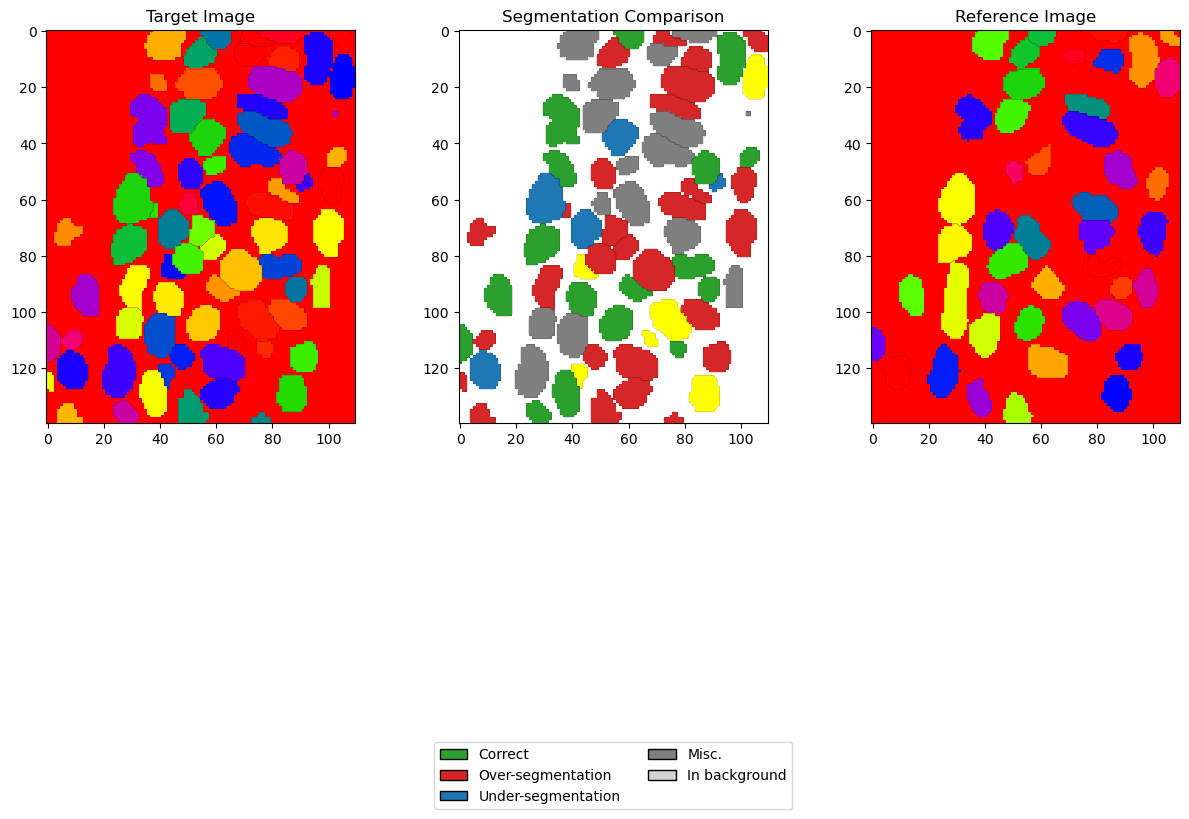

In [193]:
fig = visualize_comparison(
    target_img, reference_img, 
    stats, axis='z', slice_id=23,
    save=True
)

In [40]:
def JI(gt, pred):
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    # # Add the missing predicted cells
    # missing = set(pred_cells) - set(association['pred'])
    # rows = []
    # if len(missing) > 0:
    #     for m in missing:
    #         rows.append({'pred': m, 'gt': 0, 'jaccard': 0})
    #     association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    
    jaccard_index = association['jaccard'].sum() / len(association)
    # print(association)
    # print(jaccard_index)
    
    return jaccard_index
    
print(JI(img_gt, img_pred))
print(JI(img_gt, img_dilated))
print(JI(img_gt, img_eroded))

0.7024260803639121
0.6692993630573248
0.5934526075371146


In [13]:
def VJI(gt, pred):
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    # # Add the missing predicted cells
    # missing = set(pred_cells) - set(association['pred'])
    # rows = []
    # if len(missing) > 0:
    #     for m in missing:
    #         rows.append({'pred': m, 'gt': 0, 'jaccard': 0})
    #     association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
            
    # Calculate volumes
    cell_gt_volumes = np.array([np.sum(gt == lab) for lab in gt_cells])
    cell_gt_volumes_dict = dict(zip(gt_cells, cell_gt_volumes))
    
    association['volume_gt'] = association.apply(lambda row: cell_gt_volumes_dict[row['gt']], axis=1)
    
    # Calculate Weighted Jaccard Index
    association['weighted_jaccard'] = association['jaccard'] * association['volume_gt']
    
    vji = association['weighted_jaccard'].sum() / np.sum(cell_gt_volumes)
    # print(association)
    # print(vji)
    
    return vji
    
print(VJI(img_gt, img_pred))
print(VJI(img_gt, img_dilated))
print(VJI(img_gt, img_eroded))

0.7024260803639121
0.6692993630573248
0.5934526075371146


In [16]:
def BFS(gt, pred, threshold=2, draw=False):
    def calc_precision_recall(contours_a, contours_b, threshold):
        x = contours_a
        y = contours_b
    
        xx = np.array(x)
        xx = xx.reshape(-1, 2)
        
        yy = np.array(y)
        yy = yy.reshape(-1, 2)
        hits = []
        for yrec in yy:
            d = np.square(xx[:,0] - yrec[0]) + np.square(xx[:,1] - yrec[1])
            hits.append(np.any(d < threshold*threshold))
        top_count = np.sum(hits)
    
        try:
            precision_recall = top_count / len(y)
        except ZeroDivisionError:
            precision_recall = 0
    
        return precision_recall, top_count, len(y)
    
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    # # Add the missing predicted cells
    # missing = set(pred_cells) - set(association['pred'])
    # rows = []
    # if len(missing) > 0:
    #     for m in missing:
    #         rows.append({'pred': m, 'gt': 0, 'jaccard': 0})
    #     association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
            
    # print(association)
            
    bfscores = []
    volumes_gt = []
        
    for id in association['gt']:
        gt_mask = gt == id
        
        contours, _ = cv2.findContours(
            gt_mask.astype(np.uint8), cv2.RETR_LIST, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        contours_gt = []
        for i in range(len(contours)):
            for j in range(len(contours[i])):
                contours_gt.append(contours[i][j])
                
        if contours_gt:
            volume = cv2.contourArea(np.array(contours_gt))
            volumes_gt.append(volume)
    
        if draw:
            img = np.zeros(shape=(gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
            img[gt == id, 0] = 128
            img = cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
    
        try:
            associated_id = association.loc[association['gt'] == id, 'pred'].values[0]
        except IndexError:
            associated_id = 0
            
        if associated_id == 0:
            bfscores.append(0)
            continue
        
        pred_mask = pred == associated_id
        
        contours, _ = cv2.findContours(
            pred_mask.astype(np.uint8), cv2.RETR_LIST, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        contours_pred = []
        for i in range(len(contours)):
            for j in range(len(contours[i])):
                contours_pred.append(contours[i][j])
                
        if draw:
            img[pred == associated_id, 2] = 128
            img = cv2.drawContours(img, contours, -1, (0, 0, 255), 1)
            
        precission, num, den = calc_precision_recall(contours_gt, contours_pred, threshold)
        print(precission, num, den)
        
        recall, num, den = calc_precision_recall(contours_pred, contours_gt, threshold)
#         print(recall, num, den)
        
        try:
            bfscore = 2 * precission * recall / (precission + recall)
        except ZeroDivisionError:
            bfscore = 0
            
        bfscores.append(bfscore)
        
        if draw:
            cv2.imshow('img', img)
            cv2.waitKey(0)
            
    association['bfscore'] = bfscores  
    association['w_bfscore'] = association['bfscore'] * np.array(volumes_gt)
    
    total_volume = np.nansum(volumes_gt)
    bfscore = np.nanmean(bfscores)
    fw_bfscore = np.nansum(
        [score * volume for score, volume in zip(bfscores, volumes_gt)]
    ) / total_volume
    
#     print(bfscore, fw_bfscore)
    
    if draw:
        cv2.destroyAllWindows()
    
    return bfscore, fw_bfscore

# print(BFS(img_gt, img_pred))
# print(BFS(img_gt, img_dilated))
# print(BFS(img_gt, img_eroded))

In [17]:
def dice_coef(gt, pred):
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    dices = []
    for id in association['gt']:
        gt_mask = gt == id
        try:
            associated_id = association.loc[association['gt'] == id, 'pred'].values[0]
        except IndexError:
            associated_id = 0
            
        if associated_id == 0:
            continue
        
        pred_mask = pred == associated_id
        
        intersection = np.logical_and(pred_mask, gt_mask).sum()
        total = np.sum(gt_mask) + np.sum(pred_mask)
        dices.append(np.mean(2 * intersection / total))
        
    dice = np.nanmean(dices)
    
    return dice

print(dice_coef(img_gt, img_pred))
print(dice_coef(img_gt, img_dilated))
print(dice_coef(img_gt, img_eroded))

0.8252059674905367
0.8018925518925519
0.7448638318203535
